# Plug and Play ADMM with pretrained denoiser

In [1]:
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
from skimage.transform import iradon

import scipy as sp
import pylab
import h5py

import torch
import torchvision
import torchvision.transforms as transforms
import time

## Data loading:

Projection matrix $A$:

In [2]:
import scipy.io
mat = scipy.io.loadmat('projection_matrices/thinL64_90')
A = np.array( mat['H'].todense() )

In [3]:
A.shape

(8100, 4096)

Importing brain dataset:

In [4]:
import h5py

In [5]:
brains = []
for i in range(1, 767):
    with  h5py.File('brains-master/%s.mat' %i, 'r') as f:
        brain = np.array(f['cjdata']['image'])
        brain = brain[::8, ::8]
        brains += [(brain - np.min(brain)) / (np.max(brain) - np.min(brain))]

brains = np.array(brains)
print(brains.shape)

(766, 64, 64)


Computing projections of each 2D image:

In [6]:
projections = []
for i in range(brains.shape[0]):
    p = np.matmul(A, brains[i].flatten())
    p = p.reshape((90,90))
    projections += [p]
    
projections = np.array(projections)
print(projections.shape)

(766, 90, 90)


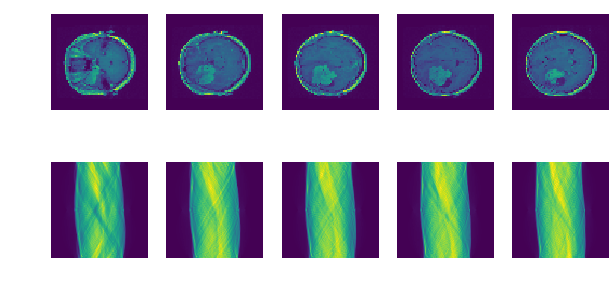

In [7]:
fig=plt.figure(figsize=(10, 5))

for i in range(5):
    idx = np.random.randint(766)
    fig.add_subplot(2, 5, i+1)
    plt.imshow(brains[i])
    plt.axis('off')
    fig.add_subplot(2, 5, i+6)
    plt.imshow(projections[i])
    plt.axis('off')

Add noise to sinogram acquisition:

(-0.5, 63.5, 63.5, -0.5)

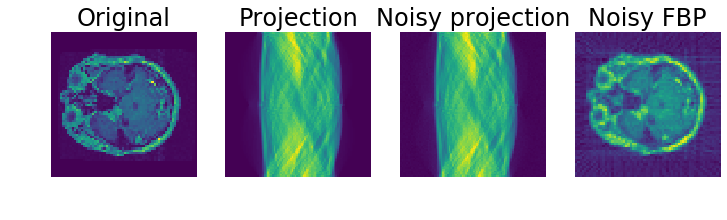

In [8]:
brain_sample = brains[5]
proj = np.matmul(A, brain_sample.flatten())
noises = np.random.uniform(5e-2, 1e-1, size=proj.shape)
proj_noisy = proj + np.random.normal(np.zeros(proj.shape), noises)
rec_fbp = np.rot90(iradon(proj_noisy.reshape(90, 90).T, output_size=64, circle=False))

fig=plt.figure(figsize=(12, 5))

fig.add_subplot(1, 4, 1)
plt.imshow(brain_sample)
plt.title("Original")
plt.axis('off')

fig.add_subplot(1, 4, 2)
plt.imshow(proj.reshape(90, 90))
plt.title("Projection")
plt.axis('off')

fig.add_subplot(1, 4, 3)
plt.imshow(proj_noisy.reshape(90, 90))
plt.title("Noisy projection")
plt.axis('off')

fig.add_subplot(1, 4, 4)
plt.imshow(rec_fbp)
plt.title("Noisy FBP")
plt.axis('off')

## Denoiser 

Here we use a pretrained denoiser. We can first observe the performance of this denoiser on some examples:

In [9]:
import torch
from denoiser.models import DnCNN

net = DnCNN(channels=1, num_of_layers=13)
net.load_state_dict(torch.load('denoiser/logs_noisy5/net.pth'))

Define image transformations (noise happens on the sinogram domain):

In [13]:
#def noisy_fbp(x, A, noise_min=1e-1, noise_max=2e1):
#    # Gray scale
#    x = x.convert('LA')
#    # Projection
#    p = np.matmul(A, np.array(x)[:,:,0].flatten())
#    # Add noise
#    noises = np.random.uniform(noise_min, noise_max, size=proj.shape)
#    p = p + np.random.normal(np.zeros(proj.shape), noises)
#    return np.rot90(iradon(p.reshape(90, 90).T, output_size=64, circle=False)).copy()

from denoiser.utils import *

transform_train = transforms.Compose([
            transforms.CenterCrop(64),
            transforms.Lambda(lambda x: noisy_fbp(x, A)),
            transforms.ToTensor(),])

Load STL10 dataset (training dataset) and observe some denoisings:

In [14]:
from denoiser.datasets import STL10

data = STL10('./STL10/', split='train', transform=transform_train, download=True)
loader_train = torch.utils.data.DataLoader(data, batch_size=10, shuffle=True, num_workers=2)

Files already downloaded and verified


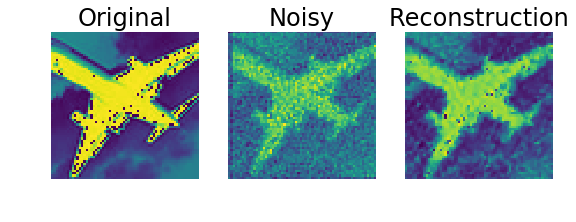

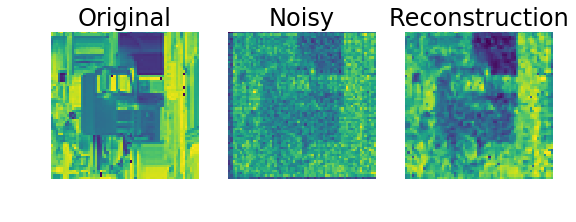

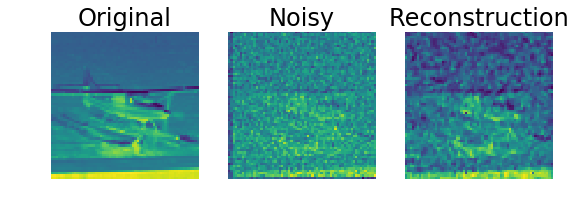

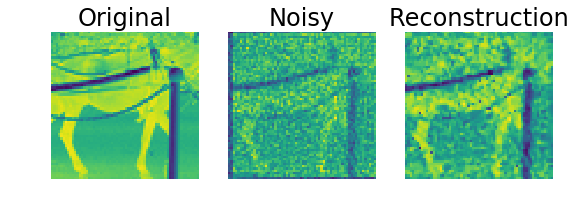

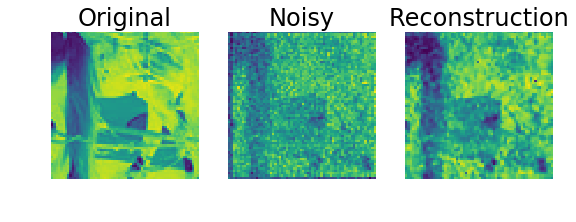

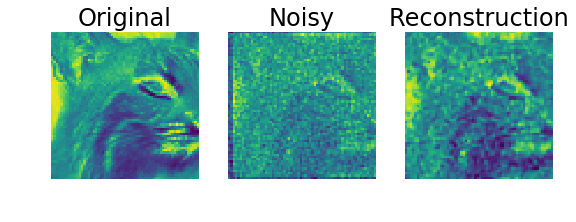

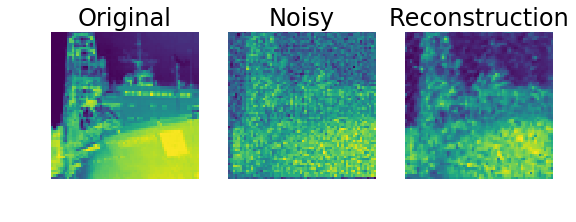

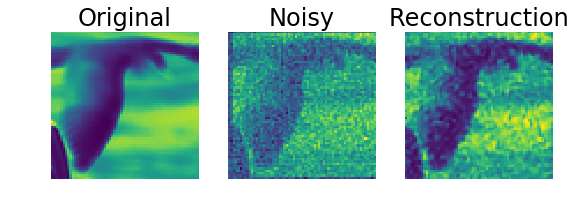

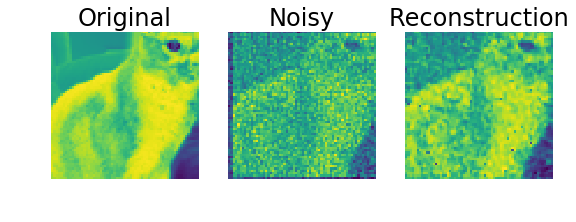

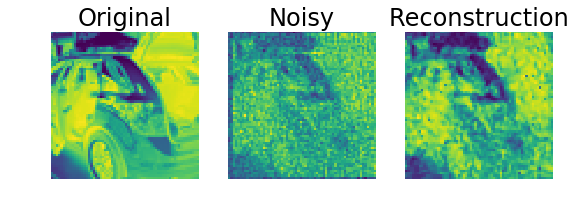

In [16]:
i = 0

for batch_idx, (image, image_noisy) in enumerate(loader_train):
    i += 1
    
    out_batch = net(image_noisy.float())
    
    for j in range(image.size()[0]):
        
        image_sample = image[j].numpy()
        image_noisy_sample = image_noisy[j].numpy()
        out_sample = out_batch[j].detach().numpy()
        
        fig=plt.figure(figsize=(9, 5))

        fig.add_subplot(1, 3, 1)
        plt.imshow(image_sample[0, :, :])
        plt.title("Original")
        plt.axis('off')

        fig.add_subplot(1, 3, 2)
        plt.imshow(image_noisy_sample[0, :, :])
        plt.title("Noisy")
        plt.axis('off')

        fig.add_subplot(1, 3, 3)
        plt.imshow(out_sample[0, :, :])
        plt.title("Reconstruction")
        plt.axis('off')
    
    if i>0:
        break

Use denoiser on brain images:

In [17]:
from utils import denoising_image

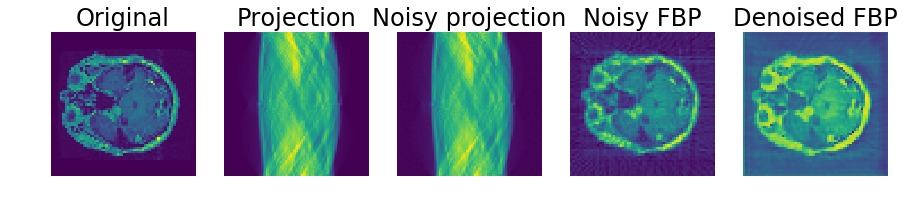

In [18]:
brain_sample = brains[5]
# Rescale brain 
brain_sample = (brain_sample - np.min(brain_sample)) / (np.max(brain_sample) - np.min(brain_sample))
proj = np.matmul(A, brain_sample.flatten())
noises = np.random.uniform(5e-2, 8e-2, size=proj.shape)
proj_noisy = proj + np.random.normal(np.zeros(proj.shape), noises)
rec_fbp = np.rot90(iradon(proj_noisy.reshape(90, 90).T, output_size=64, circle=False))

fig=plt.figure(figsize=(15, 5))

fig.add_subplot(1, 5, 1)
plt.imshow(brain_sample)
plt.title("Original")
plt.axis('off')

fig.add_subplot(1, 5, 2)
plt.imshow(proj.reshape(90, 90))
plt.title("Projection")
plt.axis('off')

fig.add_subplot(1, 5, 3)
plt.imshow(proj_noisy.reshape(90, 90))
plt.title("Noisy projection")
plt.axis('off')

fig.add_subplot(1, 5, 4)
plt.imshow(rec_fbp)
plt.title("Noisy FBP")
plt.axis('off')


fig.add_subplot(1, 5, 5)
plt.imshow(denoising_image(rec_fbp, net))
plt.title("Denoised FBP")
plt.axis('off')

plt.show()

## ADMM with pretrained denoiser:

In [19]:
from optimizers import *

Problem definition:

In [20]:
brain_sample = brains[5].flatten()

proj = np.matmul(A, brain_sample.flatten())
noises = np.random.uniform(1e-1, 9e-1, size=proj.shape)
proj = proj + np.random.normal(np.zeros(proj.shape), noises)

x0 = np.zeros(brain_sample.shape[0])
rho = 1e-1

Definition of optimizer and resolution:

In [21]:
ADMM_optimizer = PlugAndPlayADMM(x0, A, rho, proj, net, save_f=True)

In [22]:
tol = 1e-2
max_iter = 200

x_pap_admm = ADMM_optimizer.solve(x0, tol, max_iter)

Duration : 11.592092990875244


Fitness to data measure along iterations:

Text(0, 0.5, 'Fitness to data')

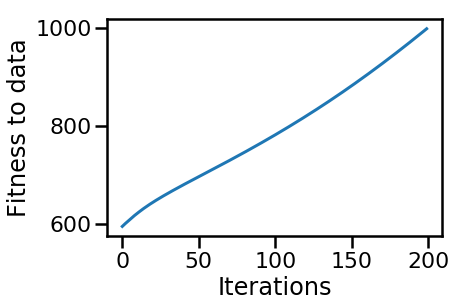

In [23]:
plt.plot([i for i in range(len(ADMM_optimizer.list_f))], ADMM_optimizer.list_f)
plt.xlabel('Iterations')
plt.ylabel('Fitness to data')

Data fitness "deteriorates" along iterations: ADMM starts from the "minimal norm solution" and progressively adds prior (here denoising) along iterations.

In [24]:
from skimage.measure.simple_metrics import compare_psnr

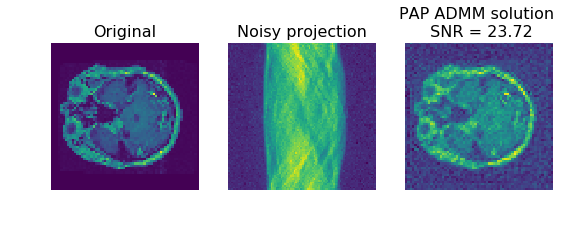

In [25]:
snr_admm = compare_psnr(brain_sample, x_pap_admm)

fig=plt.figure(figsize=(9, 5))

fig.add_subplot(1, 3, 1)
plt.imshow(brain_sample.reshape(64, 64))
plt.title("Original", fontsize=16)
plt.axis('off')

fig.add_subplot(1, 3, 2)
plt.imshow(proj.reshape(90, 90))
plt.title("Noisy projection", fontsize=16)
plt.axis('off')

fig.add_subplot(1, 3, 3)
plt.imshow(x_pap_admm.reshape(64, 64))
plt.title("PAP ADMM solution \n SNR = {0:.2f}".format(snr_admm), fontsize=16)
plt.axis('off')
plt.show()

Finding the best $\rho$:

In [134]:
#import pandas as pd
#
#rhos = np.logspace(-3, 3, 10)
#niters = np.linspace(10, 200, 4)
#columns = ['rho', 'niter', 'SNR']
#scores = pd.DataFrame(columns=columns)
#
#for rho in rhos:
#    for max_iter in niters:
#        ADMM_optimizer = PlugAndPlayADMM(x0, A, rho, proj, net, save_f=True)
#        x_pap_admm = ADMM_optimizer.solve(x0, tol, max_iter)
#        snr = compare_psnr(brain_sample, x_pap_admm)
#        line = {'rho':rho, 'niter':max_iter, 'SNR':snr}
#        print(line)
#        scores = scores.append(line, ignore_index=True)

In [135]:
# scores.iloc[scores['SNR'].idxmax()]

In [26]:
from learned_fbp import FBP

Using TensorFlow backend.


In [27]:
fbp_2500 = FBP(width=64, height=64, proj_shape=90, nb_proj=90, channels=1, sparse_reg_l1=1e-3, nb_kernels=10)
fbp_2500.fbp.load_weights('10kernels_relu_sparse_reg_dense_1e-3_batch32_2500.h5')

Instructions for updating:
Colocations handled automatically by placer.


Comparison to minimal norm and FBP solutions:

Duration : 0.6842348575592041


/mnt/disks/disk-1/anaconda3/lib/python3.7/site-packages/skimage/measure/simple_metrics.py:128: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


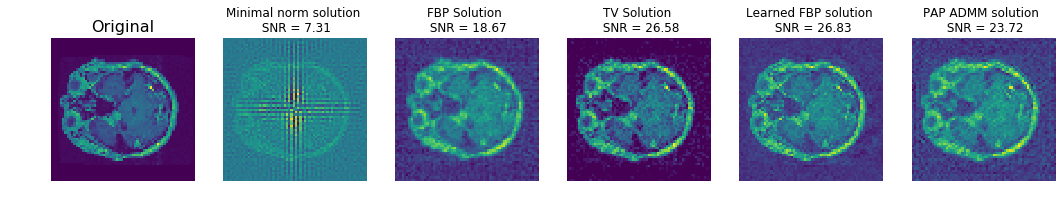

In [28]:
# Minimal norm solution
pseudo_inv = np.linalg.inv( (A.T).dot(A) )
At_proj = np.squeeze(np.array( (A.T).dot(proj) ))
z = pseudo_inv.dot(At_proj)
snr_z = compare_psnr(brain_sample, z)

# FBP solution
rec_fbp = np.rot90(iradon(proj.reshape(90, 90).T, output_size=64, circle=False))
snr_fbp = compare_psnr(brain_sample, rec_fbp.flatten())

# TV solution
epsilon = 1e-5#7
Lambda = 5e-2 #2.0e9
max_iter = 40
x0 = np.zeros(brain_sample.shape[0])
TV_opt = TVOptimizer(x0, A, proj, Lambda)
x_tv = TV_opt.solve(x0, tol, max_iter)
snr_tv = compare_psnr(brain_sample, x_tv)

# Learned FBP solution
fbp_learned_rec = fbp_2500.fbp.predict(proj.reshape(1, 90, 90, 1))
snr_learned_fbp = compare_psnr(brain_sample, fbp_learned_rec.flatten())

# Print
fig=plt.figure(figsize=(18, 6))

fig.add_subplot(1, 6, 1)
plt.imshow(brain_sample.reshape(64, 64))
plt.title("Original", fontsize=16)
plt.axis('off')

fig.add_subplot(1, 6, 2)
plt.imshow(z.reshape(64, 64))
plt.title("Minimal norm solution \n SNR = {0:.2f}".format(snr_z), fontsize=12)
plt.axis('off')

fig.add_subplot(1, 6, 3)
plt.imshow(rec_fbp)
plt.title("FBP Solution \n SNR = {0:.2f}".format(snr_fbp), fontsize=12)
plt.axis('off')

fig.add_subplot(1, 6, 4)
plt.imshow(x_tv.reshape(64, 64))
plt.title("TV Solution \n SNR = {0:.2f}".format(snr_tv), fontsize=12)
plt.axis('off')

fig.add_subplot(1, 6, 5)
plt.imshow(fbp_learned_rec[0,:,:,0])
plt.title("Learned FBP solution \n SNR = {0:.2f}".format(snr_learned_fbp), fontsize=12)
plt.axis('off')

fig.add_subplot(1, 6, 6)
plt.imshow(x_pap_admm.reshape(64, 64))
plt.title("PAP ADMM solution \n SNR = {0:.2f}".format(snr_admm), fontsize=12)
plt.axis('off')

plt.show()

In [29]:
def evaluation(i):
    
    # pb definition
    
    brain_sample = brains[i].flatten()

    proj = np.matmul(A, brain_sample.flatten())
    noises = np.random.uniform(1e-1, 9e-1, size=proj.shape)
    proj = proj + np.random.normal(np.zeros(proj.shape), noises)

    
    # admm
    x0 = np.zeros(brain_sample.shape[0])
    rho = 1e-1
    ADMM_optimizer = PlugAndPlayADMM(x0, A, rho, proj, net, save_f=True)
    tol = 1e-2
    max_iter = 200
    x_pap_admm = ADMM_optimizer.solve(x0, tol, max_iter)
    snr_admm = compare_psnr(brain_sample, x_pap_admm)
    
    # Minimal norm solution
    pseudo_inv = np.linalg.inv( (A.T).dot(A) )
    At_proj = np.squeeze(np.array( (A.T).dot(proj) ))
    z = pseudo_inv.dot(At_proj)
    snr_z = compare_psnr(brain_sample, z)

    # FBP solution
    rec_fbp = np.rot90(iradon(proj.reshape(90, 90).T, output_size=64, circle=False))
    snr_fbp = compare_psnr(brain_sample, rec_fbp.flatten())

    # TV solution
    epsilon = 1e-5#7
    Lambda = 5e-2 #2.0e9
    max_iter = 40
    x0 = np.zeros(brain_sample.shape[0])
    TV_opt = TVOptimizer(x0, A, proj, Lambda)
    x_tv = TV_opt.solve(x0, tol, max_iter)
    snr_tv = compare_psnr(brain_sample, x_tv)

    # Learned FBP solution
    fbp_learned_rec = fbp_2500.fbp.predict(proj.reshape(1, 90, 90, 1))
    snr_learned_fbp = compare_psnr(brain_sample, fbp_learned_rec.flatten())

    # Print
    fig=plt.figure(figsize=(18, 6))

    fig.add_subplot(1, 6, 1)
    plt.imshow(brain_sample.reshape(64, 64))
    plt.title("Original", fontsize=16)
    plt.axis('off')

    fig.add_subplot(1, 6, 2)
    plt.imshow(z.reshape(64, 64))
    plt.title("Pseudo-inverse solution \n SNR = {0:.2f}".format(snr_z), fontsize=12)
    plt.axis('off')

    fig.add_subplot(1, 6, 3)
    plt.imshow(rec_fbp)
    plt.title("FBP Solution \n SNR = {0:.2f}".format(snr_fbp), fontsize=12)
    plt.axis('off')

    fig.add_subplot(1, 6, 4)
    plt.imshow(x_tv.reshape(64, 64))
    plt.title("TV Solution \n SNR = {0:.2f}".format(snr_tv), fontsize=12)
    plt.axis('off')

    fig.add_subplot(1, 6, 5)
    plt.imshow(fbp_learned_rec[0,:,:,0])
    plt.title("Learned FBP solution \n SNR = {0:.2f}".format(snr_learned_fbp), fontsize=12)
    plt.axis('off')

    fig.add_subplot(1, 6, 6)
    plt.imshow(x_pap_admm.reshape(64, 64))
    plt.title("PAP ADMM solution \n SNR = {0:.2f}".format(snr_admm), fontsize=12)
    plt.axis('off')
    plt.show()

    plt.show()

Duration : 10.373497486114502
Duration : 0.7285647392272949


/mnt/disks/disk-1/anaconda3/lib/python3.7/site-packages/skimage/measure/simple_metrics.py:128: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


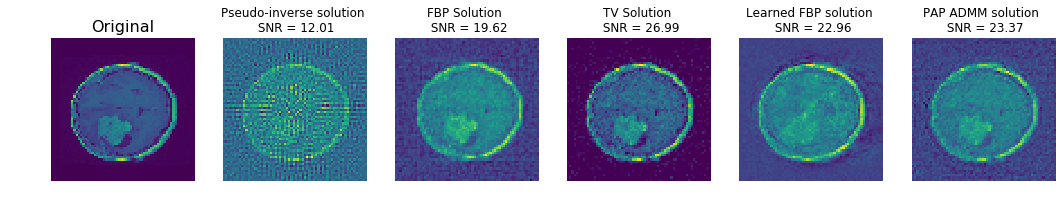

In [30]:
evaluation(3)

Duration : 12.914591789245605
Duration : 0.8125772476196289


/mnt/disks/disk-1/anaconda3/lib/python3.7/site-packages/skimage/measure/simple_metrics.py:128: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


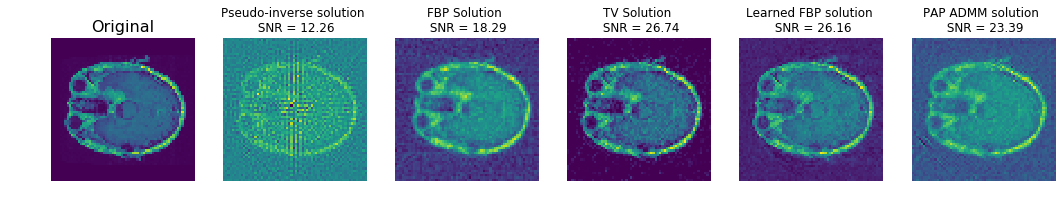

In [31]:
evaluation(100)

Duration : 10.739984035491943
Duration : 0.7445623874664307


/mnt/disks/disk-1/anaconda3/lib/python3.7/site-packages/skimage/measure/simple_metrics.py:128: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


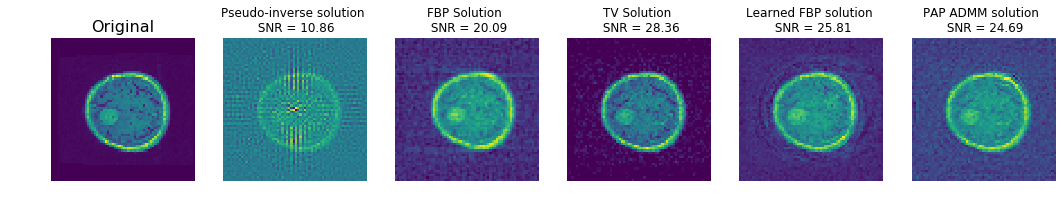

In [32]:
evaluation(200)

Duration : 10.678858518600464
Duration : 0.667466402053833


/mnt/disks/disk-1/anaconda3/lib/python3.7/site-packages/skimage/measure/simple_metrics.py:128: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


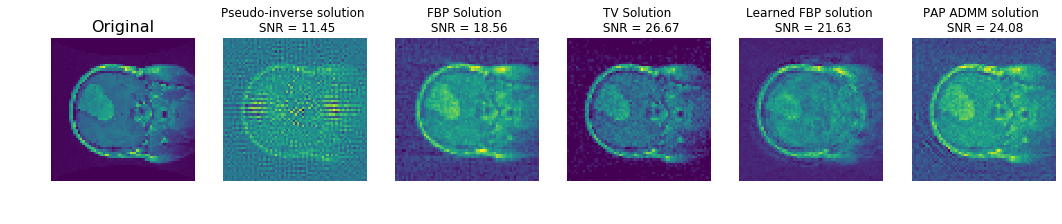

In [33]:
evaluation(300)

Duration : 10.011661767959595
Duration : 0.5006382465362549


/mnt/disks/disk-1/anaconda3/lib/python3.7/site-packages/skimage/measure/simple_metrics.py:128: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


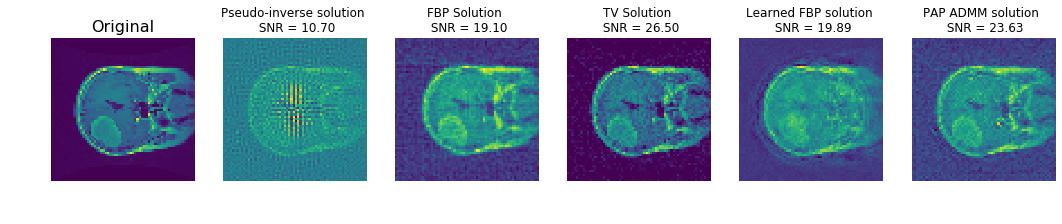

In [34]:
evaluation(400)

Duration : 10.409987688064575
Duration : 0.6386139392852783


/mnt/disks/disk-1/anaconda3/lib/python3.7/site-packages/skimage/measure/simple_metrics.py:128: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


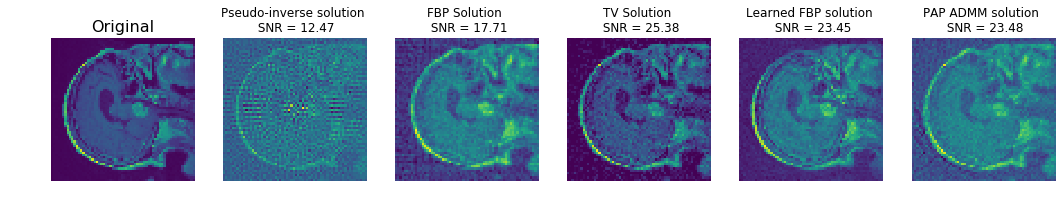

In [35]:
evaluation(500)

In [36]:
def evaluation_red(i, red_ratio=3):
    
    idx = []
    for i in range(0, 90, red_ratio):
        idx += [(90*i + j) for j in range(90)]
    
    A_red = A[idx]
    
    # pb definition
    
    brain_sample = brains[i].flatten()

    proj = np.matmul(A_red, brain_sample.flatten())
    noises = np.random.uniform(1e-1, 9e-1, size=proj.shape)
    proj = proj + np.random.normal(np.zeros(proj.shape), noises)

    
    # admm
    x0 = np.zeros(brain_sample.shape[0])
    rho = 1e-1
    ADMM_optimizer = PlugAndPlayADMM(x0, A_red, rho, proj, net, save_f=True)
    tol = 1e-2
    max_iter = 200
    x_pap_admm = ADMM_optimizer.solve(x0, tol, max_iter)
    snr_admm = compare_psnr(brain_sample, x_pap_admm)
    
    # Minimal norm solution
    pseudo_inv = np.linalg.inv( (A_red.T).dot(A_red) )
    At_proj = np.squeeze(np.array( (A_red.T).dot(proj) ))
    z = pseudo_inv.dot(At_proj)
    snr_z = compare_psnr(brain_sample, z)

    # FBP solution
    rec_fbp = np.rot90(iradon(proj.reshape(90//red_ratio, 90).T, output_size=64, circle=False))
    snr_fbp = compare_psnr(brain_sample, rec_fbp.flatten())

    # TV solution
    epsilon = 1e-5#7
    Lambda = 5e-2 #2.0e9
    max_iter = 40
    x0 = np.zeros(brain_sample.shape[0])
    TV_opt = TVOptimizer(x0, A_red, proj, Lambda)
    x_tv = TV_opt.solve(x0, tol, max_iter)
    snr_tv = compare_psnr(brain_sample, x_tv)

    
    # Print
    fig=plt.figure(figsize=(15, 5))

    fig.add_subplot(1, 5, 1)
    plt.imshow(brain_sample.reshape(64, 64))
    plt.title("Original", fontsize=16)
    plt.axis('off')

    fig.add_subplot(1, 5, 2)
    plt.imshow(z.reshape(64, 64))
    plt.title("Minimal norm solution \n SNR = {0:.2f}".format(snr_z), fontsize=12)
    plt.axis('off')

    fig.add_subplot(1, 5, 3)
    plt.imshow(rec_fbp)
    plt.title("FBP Solution \n SNR = {0:.2f}".format(snr_fbp), fontsize=12)
    plt.axis('off')

    fig.add_subplot(1, 5, 4)
    plt.imshow(x_tv.reshape(64, 64))
    plt.title("TV Solution \n SNR = {0:.2f}".format(snr_tv), fontsize=12)
    plt.axis('off')

    fig.add_subplot(1, 5, 5)
    plt.imshow(x_pap_admm.reshape(64, 64))
    plt.title("PAP ADMM solution \n SNR = {0:.2f}".format(snr_admm), fontsize=12)
    plt.axis('off')
    plt.show()

    plt.show()

Duration : 8.949556589126587
Duration : 0.39044833183288574


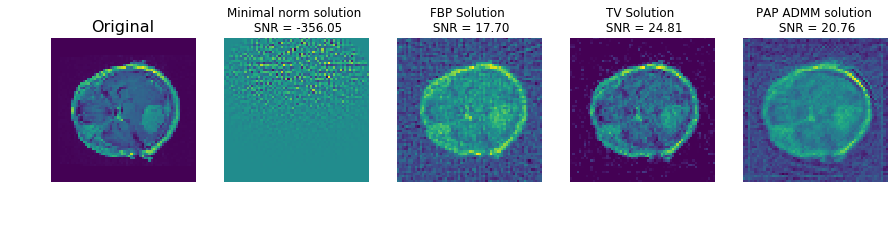

In [37]:
evaluation_red(100)

Duration : 9.156969785690308
Duration : 0.3153984546661377


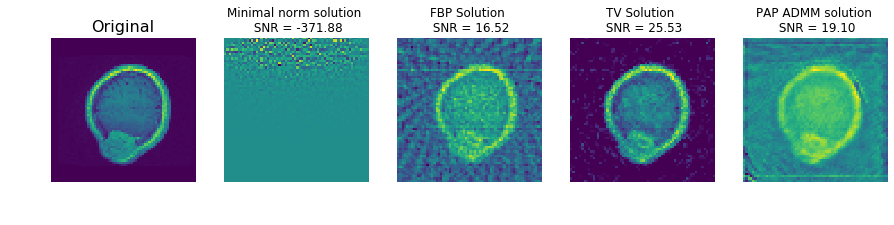

In [38]:
evaluation_red(200, red_ratio=6)